In this notebook We try to define an calculate a useful target for modeling. We aim to engineer a feature like 'Joule per kg per km'

In [118]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # plotting library
import pandas as pd
import folium

df=pd.read_parquet('/home/joelva/code/pgt-group-3/data/raw/Complete_Set/HECTORdataAggregated_20240318144231.parquet')

In [119]:
# Make a datetime column and drop the old one

# Drop the 'datetime' column
df = df.drop(columns=['datetime'])

# Rename 'Vdatetime' column to 'datetime'
df = df.rename(columns={'Vdatetime': 'datetime'})

# making a datetime column
df['datetime'] = pd.to_datetime(df['datetime'])

In [120]:
df.columns

Index(['datetime', 'BatMaxV', 'BatMinV', 'BatSOC', 'BatTotalCurrent',
       'BatTotalVoltage', 'CompOnOff', 'StopOnOff', 'ThrottlePerc',
       'BrakePerc', 'Signal', 'TotalDistance', 'FrontAxle', 'RearAxle1',
       'RearAxle2', 'CompPower', 'FC2AirFlow', 'FC2Cool', 'FC2Current',
       'FC2Volt', 'FC3AirFlow', 'FC3Cool', 'FC3Current', 'FC3Volt',
       'FC1AirFlow', 'FC1Cool', 'FC1Current', 'FC1Volt', 'GPSAltitude',
       'GPSLatitude', 'GPSLongitude', 'H2Perc', 'H2Press', 'H2Temp',
       'H2Weight', 'HVACDraw', 'MotorRPM', 'MotorTorque', 'MotorUseCurrent',
       'MotorTemp', 'BattOutputPower', 'MotorPowerDraw', 'TotalFCPower',
       'ActualSpeed', 'TotalPowerDraw', 'AirTemp'],
      dtype='object')

In [121]:
%run -i './Utilities.ipynb'

In [5]:
pip install folium


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [123]:
#Route per week based on PokoCode 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def route_per_week(df, start_date, datetime_column='Vdatetime'):
    # Check if the necessary columns are present in the DataFrame
    required_columns = [datetime_column, 'GPSLatitude', 'GPSLongitude']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")

    # Proceed with filtering
    filtered_df = df.dropna(subset=required_columns)
    filtered_df = filtered_df[(filtered_df['GPSLatitude'] > 0) & (filtered_df['GPSLongitude'] > 0)]

    # Convert start_date and 'datetime_column' to datetime
    start_date = pd.to_datetime(start_date)
    filtered_df[datetime_column] = pd.to_datetime(filtered_df[datetime_column])

    # Calculate end_date as 7 days after start_date
    end_date = start_date + pd.Timedelta(days=7)
    filtered_df = filtered_df[(filtered_df[datetime_column] >= start_date) & (filtered_df[datetime_column] <= end_date)]
    
    # Add a 'day_of_week' column
    filtered_df['day_of_week'] = filtered_df[datetime_column].dt.dayofweek

    # Set the style and start plotting
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for day in range(7):
        day_df = filtered_df[filtered_df['day_of_week'] == day]
        if not day_df.empty:
            plt.plot(day_df['GPSLongitude'], day_df['GPSLatitude'], marker='o', linestyle='-', label=day_names[day])

    plt.title(f'Routes in the Week Starting from {start_date.strftime("%Y-%m-%d")}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Day of Week')
    plt.show()



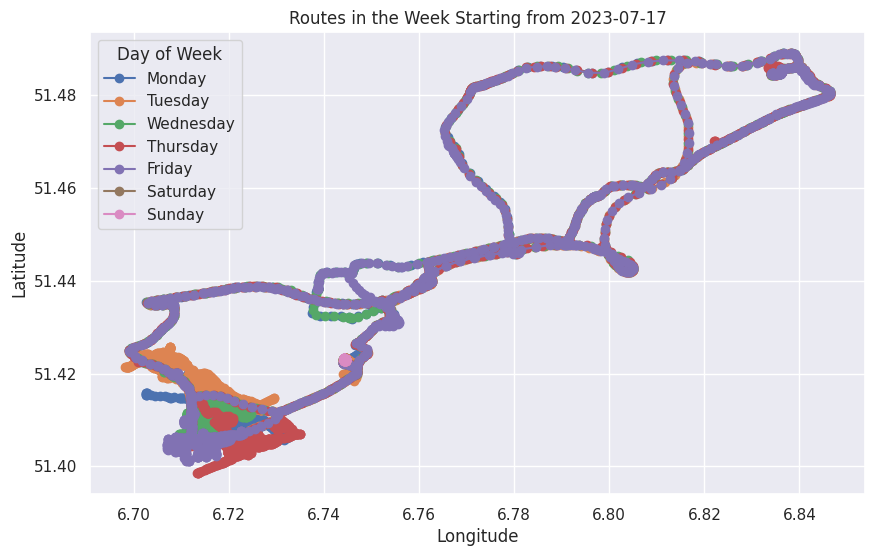

In [79]:
route_per_week(df, '2023-07-17', datetime_column='datetime')

In [130]:
#Route per day ,  Run for one specific day of the week over the complete dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def route_per_day(df, day_of_week, datetime_column='Vdatetime'):
    # Check if the necessary columns are present in the DataFrame
    required_columns = [datetime_column, 'GPSLatitude', 'GPSLongitude']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")

    # Proceed with filtering
    filtered_df = df.dropna(subset=required_columns)
    filtered_df = filtered_df[(filtered_df['GPSLatitude'] > 0) & (filtered_df['GPSLongitude'] > 0)]

    # Convert 'datetime_column' to datetime
    filtered_df[datetime_column] = pd.to_datetime(filtered_df[datetime_column])

    # Map day names to day numbers
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_number = day_names.index(day_of_week)

    # Filter the DataFrame for the specified day of the week across all dates
    filtered_df['day_of_week'] = filtered_df[datetime_column].dt.dayofweek
    filtered_df = filtered_df[filtered_df['day_of_week'] == day_number]

    # Set the style and start plotting
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))

    # Since we're plotting routes for the same day across all dates, we use different colors or markers
    unique_dates = filtered_df[datetime_column].dt.date.unique()
    for date in unique_dates:
        day_df = filtered_df[filtered_df[datetime_column].dt.date == date]
        if not day_df.empty:
            plt.plot(day_df['GPSLongitude'], day_df['GPSLatitude'], marker='o', linestyle='-', label=str(date))

    plt.title(f'Routes for {day_of_week}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


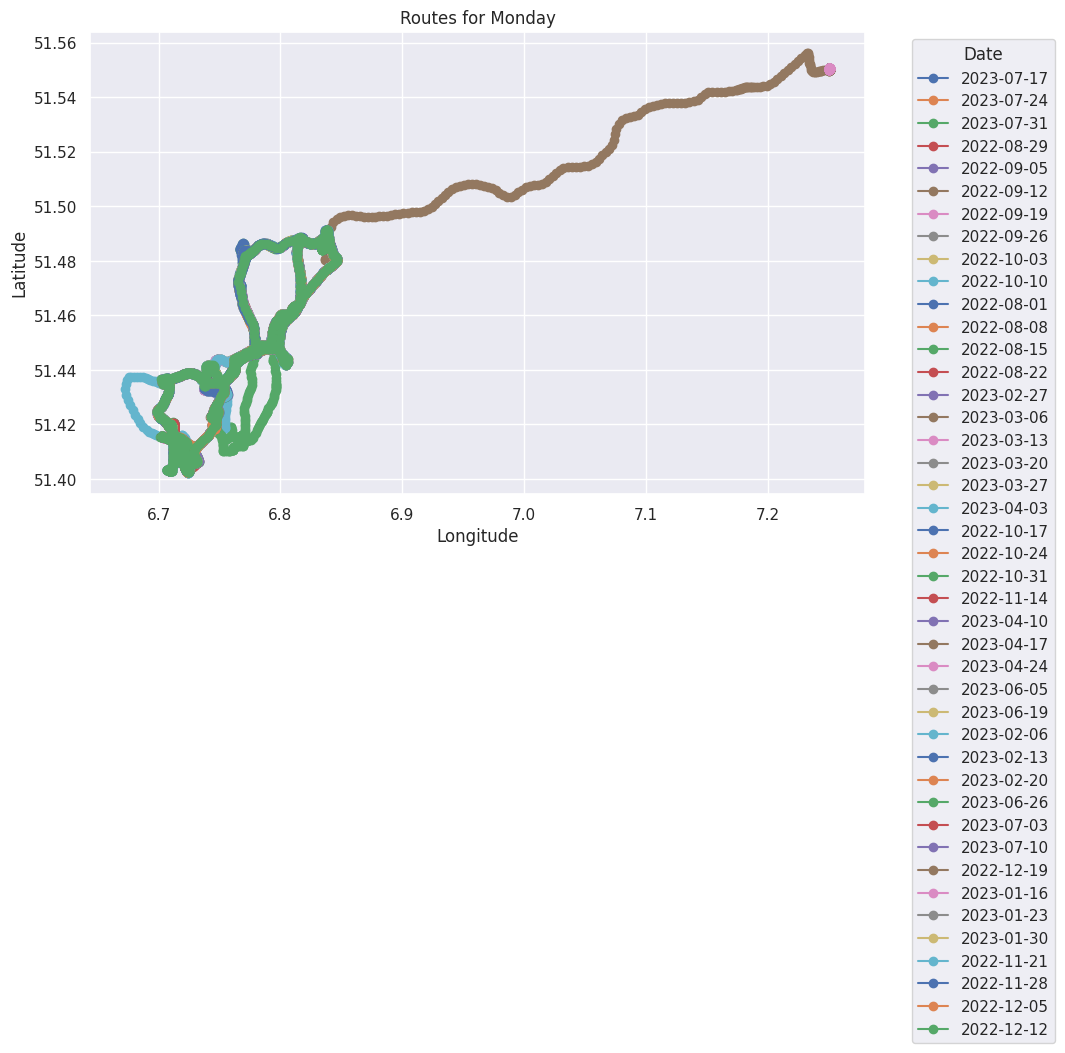

In [129]:
route_per_day(df, 'Monday', datetime_column='datetime')


In [131]:
#Route per day on folium map
import pandas as pd
import folium

def route_per_day(df, day_of_week, datetime_column='Vdatetime'):
    # Check if the necessary columns are present in the DataFrame
    required_columns = [datetime_column, 'GPSLatitude', 'GPSLongitude']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")

    # Proceed with filtering
    filtered_df = df.dropna(subset=required_columns)
    filtered_df = filtered_df[(filtered_df['GPSLatitude'] > 0) & (filtered_df['GPSLongitude'] > 0)]

    # Convert 'datetime_column' to datetime
    filtered_df[datetime_column] = pd.to_datetime(filtered_df[datetime_column])

    # Map day names to day numbers
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_number = day_names.index(day_of_week)

    # Filter the DataFrame for the specified day of the week across all dates
    filtered_df['day_of_week'] = filtered_df[datetime_column].dt.dayofweek
    filtered_df = filtered_df[filtered_df['day_of_week'] == day_number]

    # Generate map
    if not filtered_df.empty:
        # Start the map in the geographic center of the data
        start_lat = filtered_df['GPSLatitude'].mean()
        start_lon = filtered_df['GPSLongitude'].mean()
        map = folium.Map(location=[start_lat, start_lon], zoom_start=12)

        # Group data by date to plot each date as a separate layer
        grouped = filtered_df.groupby(filtered_df[datetime_column].dt.date)
        for date, group in grouped:
            route = folium.PolyLine(
                locations=list(zip(group['GPSLatitude'], group['GPSLongitude'])),
                weight=5,
                color='blue'
            ).add_to(map)
            folium.Marker(
                location=[group['GPSLatitude'].iloc[0], group['GPSLongitude'].iloc[0]],
                popup=f'Start: {date}',
                icon=folium.Icon(color='green')
            ).add_to(map)
            folium.Marker(
                location=[group['GPSLatitude'].iloc[-1], group['GPSLongitude'].iloc[-1]],
                popup=f'End: {date}',
                icon=folium.Icon(color='red')
            ).add_to(map)

        return map
    else:
        print("No data available for the selected day.")
        return None


In [132]:
map = route_per_day(df, 'Monday', datetime_column='datetime')
map.save('Monday_routes.html')  # Save to HTML file
map  # Display in Jupyter notebook


In [48]:
pip install shapely


  Obtaining dependency information for shapely from https://files.pythonhosted.org/packages/d5/fb/bcf6a8164ed307c99f1a8fabe5acd86ac99a33f52530a3ca84b0936f95bd/shapely-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install geopy

  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e5/15/cf2a69ade4b194aa524ac75112d5caac37414b20a3a03e6865dfe0bd1539/geopy-2.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for geographiclib<3,>=1.52 from https://files.pythonhosted.org/packages/9f/5a/a26132406f1f40cf51ea349a5f11b0a46cec02a2031ff82e391c2537247a/geographiclib-2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [112]:
#check which days has deviation from the routes for multiple days, print the datess that deviates more than 1 kilomenter
import pandas as pd
from geopy.distance import geodesic

def route_deviation_per_days(df, days, datetime_column='Vdatetime'):
    required_columns = [datetime_column, 'GPSLatitude', 'GPSLongitude']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame is missing one or more required columns: {', '.join(required_columns)}")

    df = df.dropna(subset=['GPSLatitude', 'GPSLongitude'])
    df = df[(df['GPSLatitude'] != 0) & (df['GPSLongitude'] != 0)]
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_numbers = [day_names.index(day) for day in days if day in day_names]
    df['day_of_week'] = df[datetime_column].dt.dayofweek
    df = df[df['day_of_week'].isin(day_numbers)]

    for day in days:
        print(f"Day of Week: {day}")
        day_df = df[df['day_of_week'] == day_names.index(day)]
        grouped = day_df.groupby(day_df[datetime_column].dt.date)
        route_counts = grouped.apply(lambda x: tuple(zip(x['GPSLatitude'], x['GPSLongitude']))).value_counts()
        if route_counts.empty:
            print(f"No data available for {day}.")
            continue

        most_common_route = route_counts.idxmax()
        total_distance = 0
        for i in range(len(most_common_route) - 1):
            if pd.isna(most_common_route[i][0]) or pd.isna(most_common_route[i][1]) or pd.isna(most_common_route[i+1][0]) or pd.isna(most_common_route[i+1][1]):
                continue
            total_distance += geodesic(most_common_route[i], most_common_route[i+1]).kilometers

        print(f"Total distance of the most common route: {total_distance:.2f} kilometers.")

        for date, group in grouped:
            route = list(zip(group['GPSLatitude'], group['GPSLongitude']))
            if len(route) < 2:
                print(f"{date}: Insufficient data points to determine deviation.")
                continue
            route_line = LineString(route)
            most_common_line = LineString(most_common_route)
            np1, np2 = nearest_points(route_line, most_common_line)
            distance = geodesic((np1.y, np1.x), (np2.y, np2.x)).kilometers

            deviation = "longer" if distance > total_distance else "shorter"
            if distance > 1:
                print(f"{date}: Significant deviation on {day}: The route deviates by {distance:.2f} kilometers from the common route and is {deviation}.")





In [133]:
# Run function for multiple days
route_deviation_per_days(df, ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'], datetime_column='datetime')

Day of Week: Monday
Total distance of the most common route: 91.67 kilometers.
2023-03-13: Significant deviation on Monday: The route deviates by 45.27 kilometers from the common route and is shorter.
2023-03-20: Significant deviation on Monday: The route deviates by 45.32 kilometers from the common route and is shorter.
2023-04-17: Significant deviation on Monday: The route deviates by 45.26 kilometers from the common route and is shorter.
2023-04-24: Significant deviation on Monday: The route deviates by 45.28 kilometers from the common route and is shorter.
Day of Week: Tuesday
Total distance of the most common route: 100.20 kilometers.


/home/joelva/.pyenv/versions/3.11.5/lib/python3.11/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


2022-12-27: Significant deviation on Tuesday: The route deviates by 45.61 kilometers from the common route and is shorter.
2023-03-07: Significant deviation on Tuesday: The route deviates by 45.90 kilometers from the common route and is shorter.
2023-04-18: Significant deviation on Tuesday: The route deviates by 45.77 kilometers from the common route and is shorter.
2023-04-25: Significant deviation on Tuesday: The route deviates by 45.84 kilometers from the common route and is shorter.
Day of Week: Wednesday
Total distance of the most common route: 88.36 kilometers.
2022-12-28: Significant deviation on Wednesday: The route deviates by 45.27 kilometers from the common route and is shorter.
2023-03-15: Significant deviation on Wednesday: The route deviates by 45.34 kilometers from the common route and is shorter.
2023-03-22: Significant deviation on Wednesday: The route deviates by 45.32 kilometers from the common route and is shorter.
2023-04-19: Significant deviation on Wednesday: The

/home/joelva/.pyenv/versions/3.11.5/lib/python3.11/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


2023-03-16: Significant deviation on Thursday: The route deviates by 45.91 kilometers from the common route and is shorter.
2023-04-13: Significant deviation on Thursday: The route deviates by 45.89 kilometers from the common route and is shorter.
2023-04-20: Significant deviation on Thursday: The route deviates by 45.90 kilometers from the common route and is shorter.
2023-04-27: Significant deviation on Thursday: The route deviates by 44.04 kilometers from the common route and is shorter.
Day of Week: Friday
Total distance of the most common route: 94.95 kilometers.
2022-12-23: Significant deviation on Friday: The route deviates by 45.27 kilometers from the common route and is shorter.
2022-12-30: Significant deviation on Friday: The route deviates by 45.25 kilometers from the common route and is shorter.
2023-03-17: Significant deviation on Friday: The route deviates by 45.30 kilometers from the common route and is shorter.
2023-04-14: Significant deviation on Friday: The route devi

/home/joelva/.pyenv/versions/3.11.5/lib/python3.11/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/home/joelva/.pyenv/versions/3.11.5/lib/python3.11/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


In [134]:
#function for a mapping route for a specific day
import pandas as pd
import folium
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from geopy.distance import geodesic

def route_deviation_per_day(df, day_of_week, datetime_column='Vdatetime'):
    # Check if the necessary columns are present in the DataFrame
    required_columns = [datetime_column, 'GPSLatitude', 'GPSLongitude']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")

    # Proceed with filtering
    filtered_df = df.dropna(subset=required_columns)
    filtered_df = filtered_df[(filtered_df['GPSLatitude'] > 0) & (filtered_df['GPSLongitude'] > 0)]

    # Convert 'datetime_column' to datetime
    filtered_df[datetime_column] = pd.to_datetime(filtered_df[datetime_column])

    # Map day names to day numbers
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_number = day_names.index(day_of_week)

    # Filter the DataFrame for the specified day of the week across all dates
    filtered_df['day_of_week'] = filtered_df[datetime_column].dt.dayofweek
    filtered_df = filtered_df[filtered_df['day_of_week'] == day_number]

    # Group data by date to determine the most common route
    grouped = filtered_df.groupby(filtered_df[datetime_column].dt.date)
    route_counts = grouped.apply(lambda x: tuple(zip(x['GPSLatitude'], x['GPSLongitude']))).value_counts()
    most_common_route = route_counts.idxmax()

    # Calculate total distance of the most common route
    total_distance = sum(geodesic((most_common_route[i][0], most_common_route[i][1]), 
                                  (most_common_route[i+1][0], most_common_route[i+1][1])).kilometers 
                         for i in range(len(most_common_route)-1))

    print(f"Total distance of the most common route: {total_distance:.2f} kilometers.")

    # Generate map
    if not filtered_df.empty:
        start_lat = filtered_df['GPSLatitude'].mean()
        start_lon = filtered_df['GPSLongitude'].mean()
        map = folium.Map(location=[start_lat, start_lon], zoom_start=12)

        # Most common route as a LineString for distance calculations
        most_common_line = LineString(most_common_route)

        for date, group in grouped:
            route = list(zip(group['GPSLatitude'], group['GPSLongitude']))
            route_line = LineString(route)
            np1, np2 = nearest_points(route_line, most_common_line)
            distance = geodesic((np1.y, np1.x), (np2.y, np2.x)).kilometers  # Converting coordinates to km

            # Check if the distance is more than 1 km
            if distance > 1:
                color = 'red'
                print(f"Significant deviation on {date}: The route deviates by {distance:.2f} kilometers from the common route.")
            else:
                color = 'blue'
            
            folium.PolyLine(locations=route, weight=5, color=color).add_to(map)
            folium.Marker(location=route[0], popup=f'Start: {date}', icon=folium.Icon(color='green')).add_to(map)
            folium.Marker(location=route[-1], popup=f'End: {date}', icon=folium.Icon(color='red')).add_to(map)

        return map
    else:
        print("No data available for the selected day.")
        return None


In [135]:
#Run the function  the route for a specific day
map = route_deviation_per_day(df, 'Monday', datetime_column='datetime')
map.save('Monday_routes.html')  # Save to HTML file
map  # Display in Jupyter notebook

Total distance of the most common route: 91.67 kilometers.
Significant deviation on 2023-03-13: The route deviates by 45.27 kilometers from the common route.
Significant deviation on 2023-03-20: The route deviates by 45.32 kilometers from the common route.
Significant deviation on 2023-04-17: The route deviates by 45.26 kilometers from the common route.
Significant deviation on 2023-04-24: The route deviates by 45.28 kilometers from the common route.


In [136]:
map = route_deviation_per_day(df, 'Tuesday', datetime_column='datetime')
map.save('Monday_routes.html')  # Save to HTML file
map  # Display in Jupyter notebook

Total distance of the most common route: 100.20 kilometers.
Significant deviation on 2022-12-27: The route deviates by 45.61 kilometers from the common route.
Significant deviation on 2023-03-07: The route deviates by 45.90 kilometers from the common route.
Significant deviation on 2023-04-18: The route deviates by 45.77 kilometers from the common route.
Significant deviation on 2023-04-25: The route deviates by 45.84 kilometers from the common route.


/home/joelva/.pyenv/versions/3.11.5/lib/python3.11/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


COMPACTOR

Plot correlations with CompPower to get a visual of some of the data and features we will use

In [116]:
# define a function that plots the data of a given column for a single given day

def plot_single_day(df, column, day):
    """
    Plot data for a single day from a pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - column (str): Name of the column to plot.
    - day (str): Date in the format 'YYYY-MM-DD' to plot data for.
    """
    
    # Filter data for the specific day
    mask = (df['datetime'].dt.date == pd.to_datetime(day).date())
    day_data = df.loc[mask]

    # Check if there is data to plot
    if day_data.empty:
        print(f"No data available for {day}")
        return

    # Plotting
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(day_data['datetime'], day_data[column], marker='o', linestyle='-')
    plt.title(f"{column} on {day}")  # Set the title of the plot
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel(column)  # Label for the y-axis
    plt.grid(True)  # Enable grid for easier readability
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()  # Display the plot
